# Hands-On NLP — Class 3

<span style="color:magenta">Group Names:</span>

* Junjie CHEN
* Pavlo Poliuha
* Pablo Molla 

## Outline

- Better vectors: Tf-idf

- Ngrams

- Text generation

In [1]:
import re
import collections
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import decomposition, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB

In [2]:
tqdm.pandas()

nltk.download("punkt")

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.3.2
print("nltk's version:", nltk.__version__)          # 3.8.1
print("pandas's version:", pd.__version__)          # 2.1.4

sklearn's version: 1.3.0
nltk's version: 3.8.1
pandas's version: 1.5.3


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chenchenjunjie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
%config InlineBackend.figure_format="retina"  # For high DPI display

## Getting the data

In [4]:
DATA = Path("../data")

TEXT_P = DATA / "texts"

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

In [5]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open(encoding="utf-8") as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [6]:
all_df = pd.DataFrame.from_records(data, index=["id"])
all_df = all_df.drop("robotics.stackexchange_0000005103")
all_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0
...,...,...,...
portuguese.stackexchange_0000001017,"Q:\n\n""pois não"" has an affirmative connotatio...",portuguese,5
portuguese.stackexchange_0000004609,"Q:\n\nPor que ""Teiú"" tem acento?\n\nMonossílab...",portuguese,5
portuguese.stackexchange_0000000484,"Q:\n\nRegional usage of ""guitarra"" and ""violão...",portuguese,5


---
Here the initialization of `all_df` is done and you can jump to your favorite classification
___

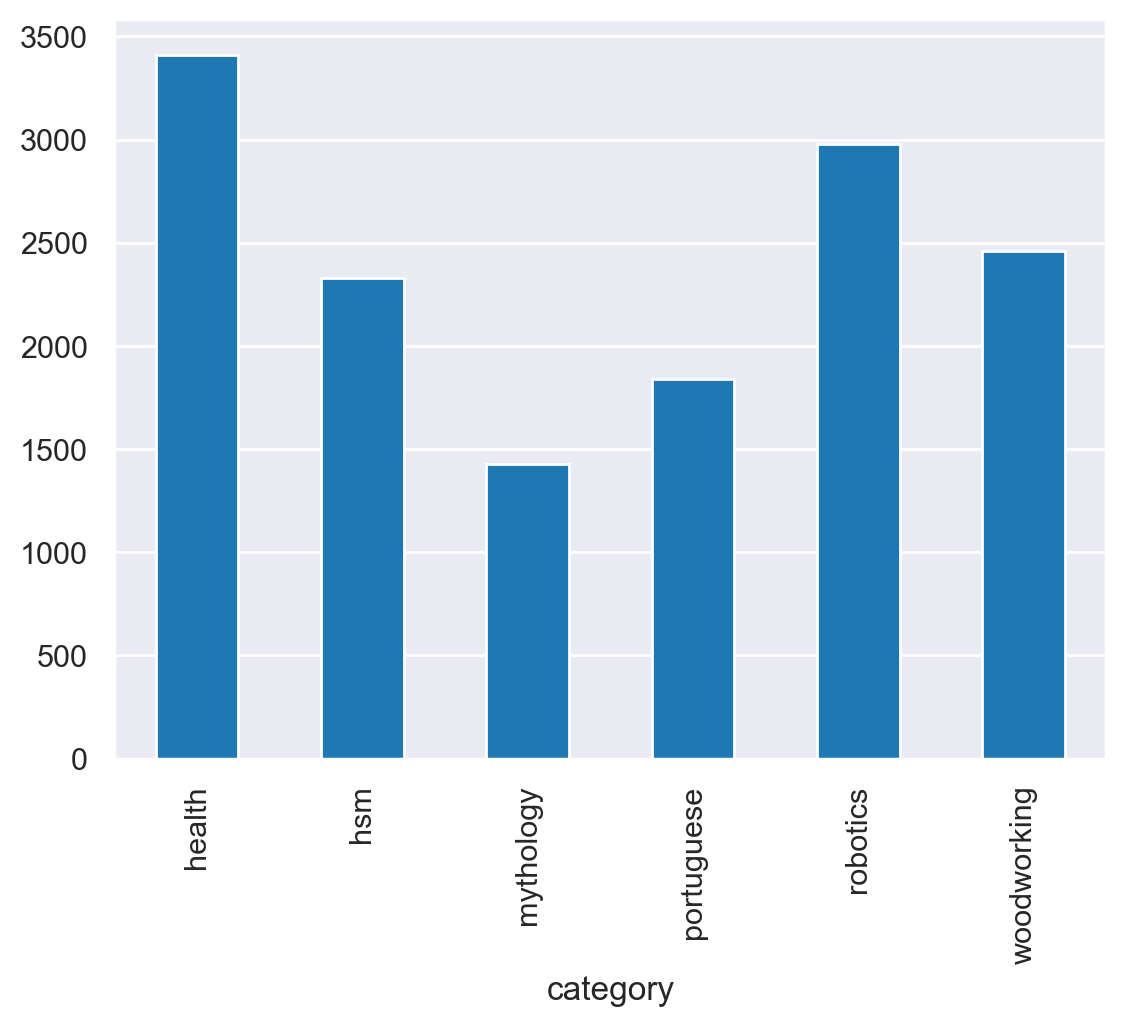

In [7]:
all_df.groupby("category").size().plot.bar()
plt.grid(axis="x")

## Vectorize

In [8]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus).toarray()

cv_df = pd.DataFrame(xs, index=corpus, columns=vectorizer.get_feature_names_out())
cv_df

,and,document,first,is,one,second,the,third,this
This is the first document.,0,1,1,1,0,0,1,0,1
This document is the second document.,0,2,0,1,0,1,1,0,1
And this is the third one.,1,0,0,1,1,0,1,1,1
Is this the first document?,0,1,1,1,0,0,1,0,1


### TF-IDF

- The counting of words is not the ideal way to represent a document

- Instead of counting the number of occurences of a word, we could weight it by the number of documents it appears in

- Term Frequency - Inverse Document Frequency

#### From [Wikipedia](https://en.wikipedia.org/wiki/Tf-idf):

**Term frequency**

$$\operatorname{tf}(t,d) = \frac{f_{t,d}}{{\sum_{t' \in d}{f_{t',d}}}}$$

**Inverse document frequency**

$$\operatorname{idf}(t, D) =  - \log \frac{|\{d \in D: t \in d\}|}{N} = 
    -\log \left({\frac {n_{t}}{N}}\right) $$

N: total number of documents in the corpus $N = {|D|}$

**Smoothed IDF:**

$$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {N}\right)+ 1$$

#### From [scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting):

In `TfidfVectorizer`, the implementation is slightly different:

*   For the IDF:

    *   Unsmoothed version (`smooth_idf=False`), though a $+1$ is applied to avoid a value of 0 for the IDF:
    $$\operatorname{idf}(t, D) = -\log \left({\frac {n_{t}}{N}}\right) + 1$$

    *   Smoothed version (`smooth_idf=True`):
    $$\operatorname{idf}(t, D) = - \log \left( \frac {1 + n_t} {1 + N}\right)+ 1$$

*   `TFIDF = tf(t, d) * idf(t, D)`

*   `tf(t, d)` is the **count** of the term `t` in the document `d`, not the **frequency** (**no division!**)

*   Then a global normalization is applied: `TFIDF = TFIDF / norm(TFIDF)`
    
    (instead of a normalization within `tf` only to obtain a frequency)

*   `norm` is the L2 norm by default, but can be changed to L1 or `None`.

#### 🚧 TODO: Count vs. Freq vectorizers

Compare the previous results of the `CountVectorizer` with the `TfidfVectorizer` on the same toy dataset.

In [9]:

transformer = TfidfVectorizer() # create a transformer
xs_tf = transformer.fit_transform(corpus).toarray() # fit the transformer to the corpus and transform the corpus

tf_idf = pd.DataFrame(xs_tf, index=corpus, columns=transformer.get_feature_names_out()) # create a dataframe from the tf-idf matrix
tf_idf


,and,document,first,is,one,second,the,third,this
This is the first document.,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841
This document is the second document.,0.0000,0.6876,0.0000,0.2811,0.0000,0.5386,0.2811,0.0000,0.2811
And this is the third one.,0.5118,0.0000,0.0000,0.2671,0.5118,0.0000,0.2671,0.5118,0.2671
Is this the first document?,0.0000,0.4698,0.5803,0.3841,0.0000,0.0000,0.3841,0.0000,0.3841


### Let's now classify the StackOverflow documents in their respective corpus label

*   The complete corpus: `all_df`

*   Let's use the different vectorizers for representation

In [10]:
ys = all_df.cat_id.values

In [11]:
cv = CountVectorizer(max_features=5000)
xs = cv.fit_transform(all_df.text).toarray()
xs

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [12]:
print("xs.shape =", xs.shape)
print("ys.shape =", ys.shape)

xs.shape = (14450, 5000)
ys.shape = (14450,)


In [13]:
train_xs, test_xs, train_ys, test_ys = train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


#### 🚧 TODO: `CountVectorizer` vs. `TfidfVectorizer` classifiers

*   Limit to the 5000 most frequent words to reduce the dimensionality

    (the sparse matrix `toarray()` method crashes if no reduction of features is applied)

*   Use both to classify the data based on, e.g., the `MultinomialNB` classifier

*   Compare their results in terms of accuracy and show their `classification_report`

In [14]:

# Initialize vectorizers
count_vectorizer = CountVectorizer(max_features=5000)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Transform data
X_count = count_vectorizer.fit_transform(all_df.text).toarray()
X_tfidf = tfidf_vectorizer.fit_transform(all_df.text).toarray()

# Initialize classifiers
clf_count = MultinomialNB()
clf_tfidf = MultinomialNB()

train_x_count, test_x_count, train_ys_count, test_ys_count = train_test_split(
    X_count, ys, test_size=0.3, random_state=0, shuffle=True
)
train_x_tf, test_x_tf, train_ys_tf, test_ys_tf = train_test_split(
    X_tfidf, ys, test_size=0.3, random_state=0, shuffle=True
)

# Train classifiers
clf_count.fit(train_x_count,train_ys_count)
clf_tfidf.fit(train_x_tf, train_ys_tf)

# Predict and evaluate
y_pred_count = clf_count.predict(test_x_count)
y_pred_tfidf = clf_tfidf.predict(test_x_tf)

print("CountVectorizer Accuracy:", accuracy_score(test_ys_count, y_pred_count))
print("CountVectorizer Classification Report:")
print(classification_report(test_ys_count, y_pred_count))


print("TfidfVectorizer Accuracy:", accuracy_score(test_ys_tf, y_pred_tfidf))
print("TfidfVectorizer Classification Report:")
print(classification_report(test_ys_tf, y_pred_tfidf))


CountVectorizer Accuracy: 0.9741637831603229
CountVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       420
           1       0.97      1.00      0.98       692
           2       0.98      0.97      0.98       935
           3       0.95      0.97      0.96       709
           4       0.98      0.98      0.98      1054
           5       1.00      0.93      0.96       525

    accuracy                           0.97      4335
   macro avg       0.97      0.97      0.97      4335
weighted avg       0.97      0.97      0.97      4335

TfidfVectorizer Accuracy: 0.9748558246828143
TfidfVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       420
           1       0.97      1.00      0.98       692
           2       0.97      0.98      0.98       935
           3       0.95      0.97      0.96       709
           4      

#### 🚧 TODO: `MultinomialNB` vs. `GaussianNB` classifiers

*   Use both to classify the data

*   Compare their results in terms of accuracy and show their `classification_report`

In [15]:

# Initialize classifiers
clf_count_gau = GaussianNB()
clf_tfidf_gau = GaussianNB()


# Train classifiers
clf_count_gau.fit(train_x_count,train_ys_count)
clf_tfidf_gau.fit(train_x_tf, train_ys_tf)

# Predict and evaluate
y_pred_count_gau = clf_count.predict(test_x_count)
y_pred_tfidf_gau = clf_tfidf.predict(test_x_tf)

print("CountVectorizer Accuracy GaussianNB:", accuracy_score(test_ys_count, y_pred_count_gau))
print("CountVectorizer Classification Report:")
print(classification_report(test_ys_count, y_pred_count_gau))


print("TfidfVectorizer Accuracy GaussianNB:", accuracy_score(test_ys_tf, y_pred_tfidf_gau))
print("TfidfVectorizer Classification Report:")
print(classification_report(test_ys_tf, y_pred_tfidf_gau))


CountVectorizer Accuracy GaussianNB: 0.9741637831603229
CountVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       420
           1       0.97      1.00      0.98       692
           2       0.98      0.97      0.98       935
           3       0.95      0.97      0.96       709
           4       0.98      0.98      0.98      1054
           5       1.00      0.93      0.96       525

    accuracy                           0.97      4335
   macro avg       0.97      0.97      0.97      4335
weighted avg       0.97      0.97      0.97      4335

TfidfVectorizer Accuracy GaussianNB: 0.9748558246828143
TfidfVectorizer Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       420
           1       0.97      1.00      0.98       692
           2       0.97      0.98      0.98       935
           3       0.95      0.97      0.96       

### Comparing both methods, the accuracy, macro average, and weighted average are identical, with both methods achieving an accuracy of 0.97. The precision, recall, and F1-score for each class are also very similar, with no significant differences observed. The consistency across both methods suggests that for this particular dataset, the choice of using either Term Frequency or TF-IDF does not significantly affect the performance of the MultinomialNB classifier. ###

#### 🚧 TODO: Confusion matrix for the MultinomialNB classifier

- Verify in a confusion matrix that the precision of portuguese is 1.00 and its recall is about 0.93 with the `MultinomialNB` classifier on the Tfidf vectorizer

- Translate this result into a sentence

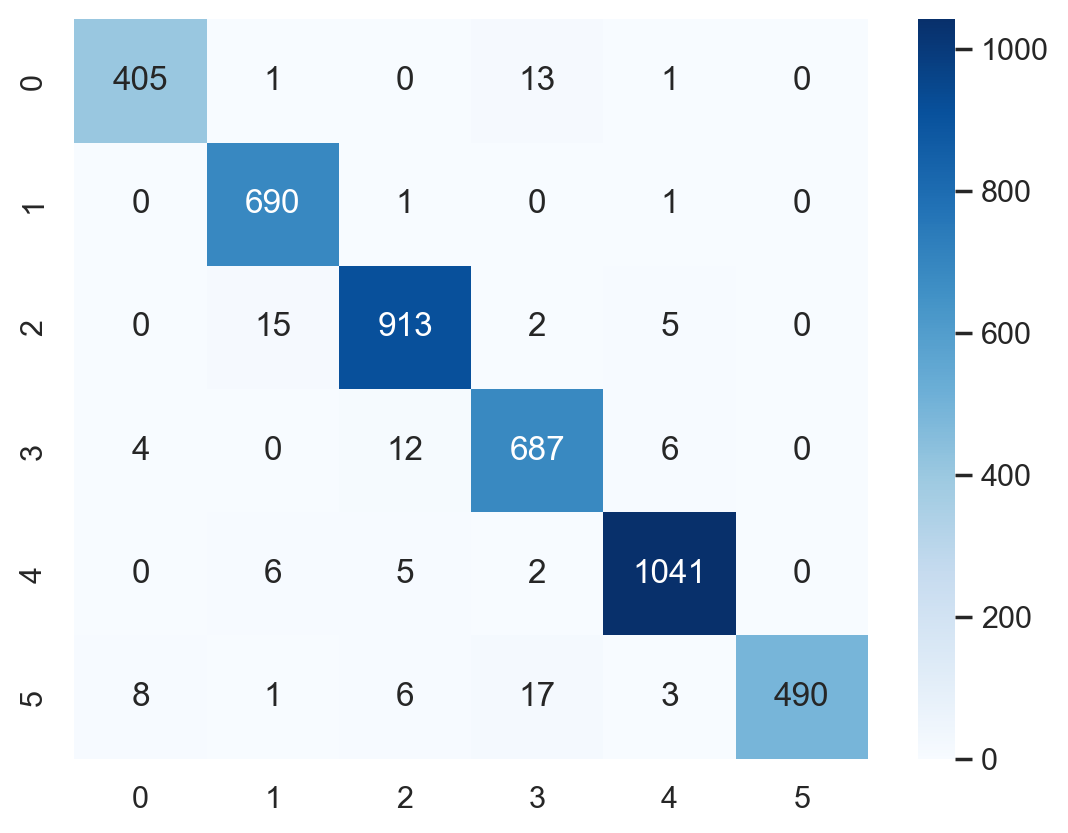

TfidfVectorizer Confusion Matrix:
[[ 405    1    0   13    1    0]
 [   0  690    1    0    1    0]
 [   0   15  913    2    5    0]
 [   4    0   12  687    6    0]
 [   0    6    5    2 1041    0]
 [   8    1    6   17    3  490]]
Precision: 1.0
Recall: 0.9333333333333333


In [16]:
from sklearn.metrics import confusion_matrix
conf_matrix_tfidf = confusion_matrix(test_ys_tf, y_pred_tfidf)
sns.heatmap(conf_matrix_tfidf, annot=True, fmt='d', cmap='Blues')
plt.show()
print("TfidfVectorizer Confusion Matrix:")
print(conf_matrix_tfidf)
# Index of the Portuguese class
i = 5

# True Positives (TP)
TP = conf_matrix_tfidf[i, i]

# False Positives (FP) - Sum of column i (for predicted class) except TP
FP = np.sum(conf_matrix_tfidf[:, i]) - TP

# False Negatives (FN) - Sum of row i (for actual class) except TP
FN = np.sum(conf_matrix_tfidf[i, :]) - TP

# Precision and Recall calculation
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)

print(f"Precision: {precision}")
print(f"Recall: {recall}")


### Explanation : ### 
precision = 1.00: The model predicts correctly all samples as Portuguese. No samples from other categories ​​were incorrectly labeled as Portuguese, i.e. there were no False Positives.
Recall = 0.93: The model successfully recognized approximately 93% of real Portuguese samples. This means that about 7% of the Portuguese samples are not correctly recognized, that is, there are false negatives (False Negatives).

#### 🚧 TODO: add the `stop_words="english"` option to the `tf_idf` vectorizer 

*   Compare the size of the `sparse_xs` for the 2 conditions (stop words included or not)

*   Retrain with the new vectorizer and the MultinomialNB classifier

*   Compare the results with the previous vectorizer

In [17]:
# Initialize vectorizers
tfidf_vectorizer_sw = TfidfVectorizer(max_features=5000,stop_words="english")
# Transform data
X_sw = tfidf_vectorizer_sw.fit_transform(all_df.text).toarray()
X_sw.shape

(14450, 5000)

In [18]:

# Initialize vectorizers
tfidf_vectorizer_no_sw = TfidfVectorizer(max_features=100000) ## Here we use 100000 features, because we haven't sufficient memory to use all features
# Transform data
X_no_sw = tfidf_vectorizer_no_sw.fit_transform(all_df.text).toarray()
X_no_sw.shape

(14450, 100000)

In [19]:
# split data without stopwords
train_x_sw, test_x_sw, train_ys_sw, test_ys_sw = train_test_split(
    X_sw, ys, test_size=0.3, random_state=0, shuffle=True
)

In [20]:
# split data with stopwords
train_x_nosw, test_x_nosw, train_ys_nosw, test_ys_nosw = train_test_split(
    X_no_sw, ys, test_size=0.3, random_state=0, shuffle=True
)


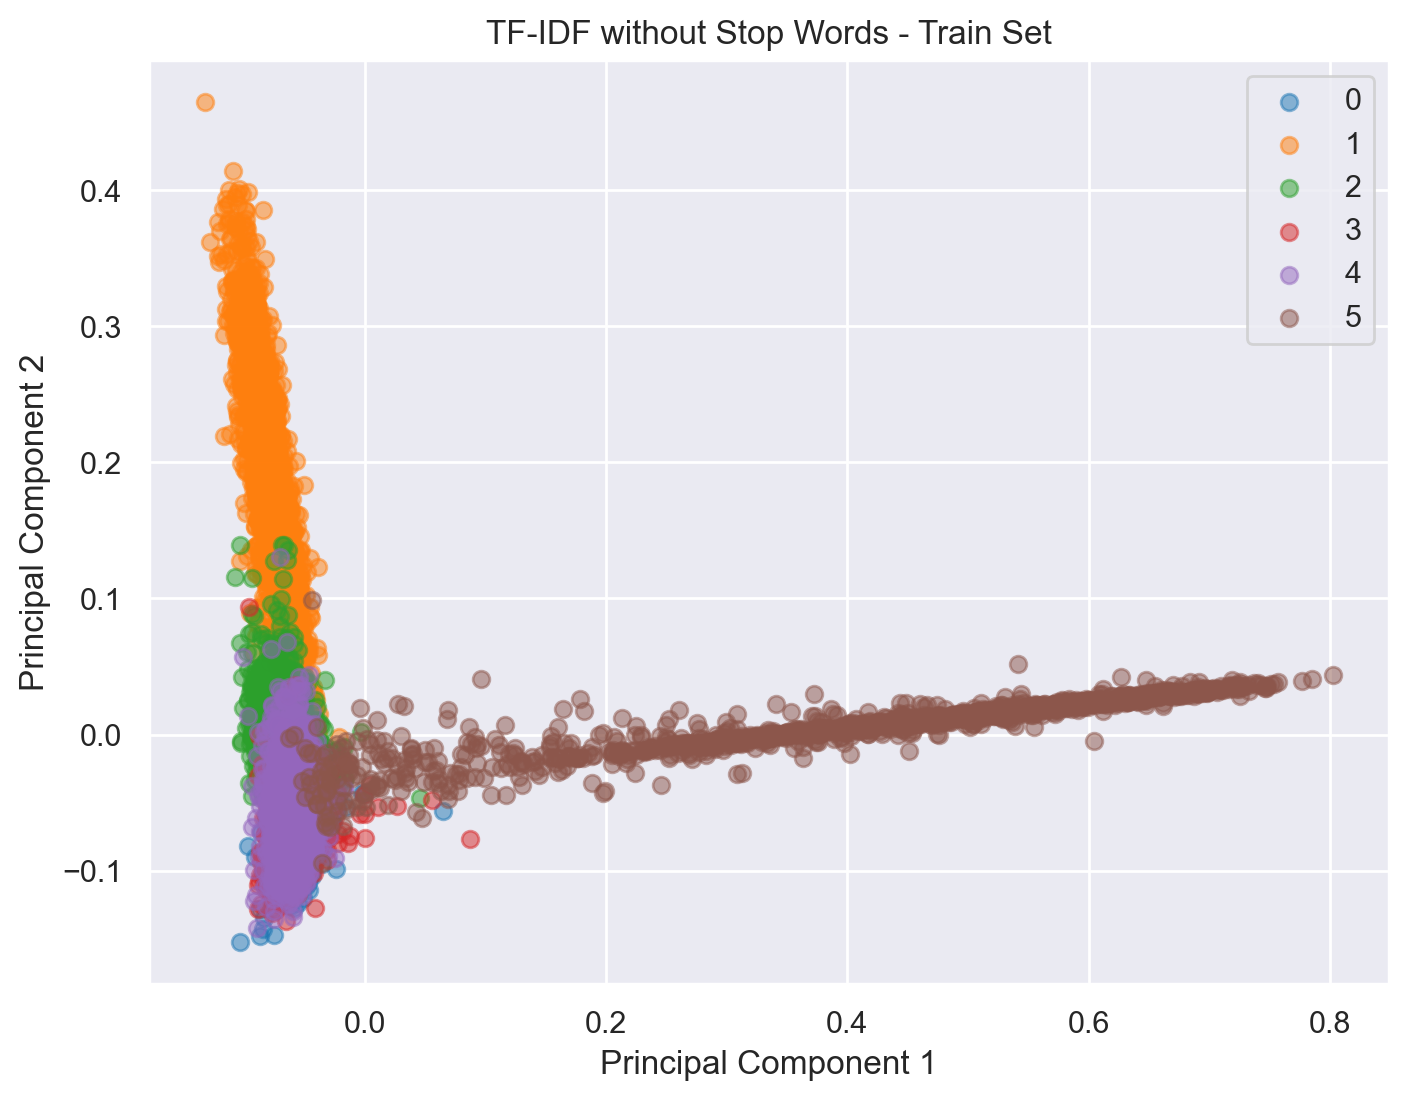

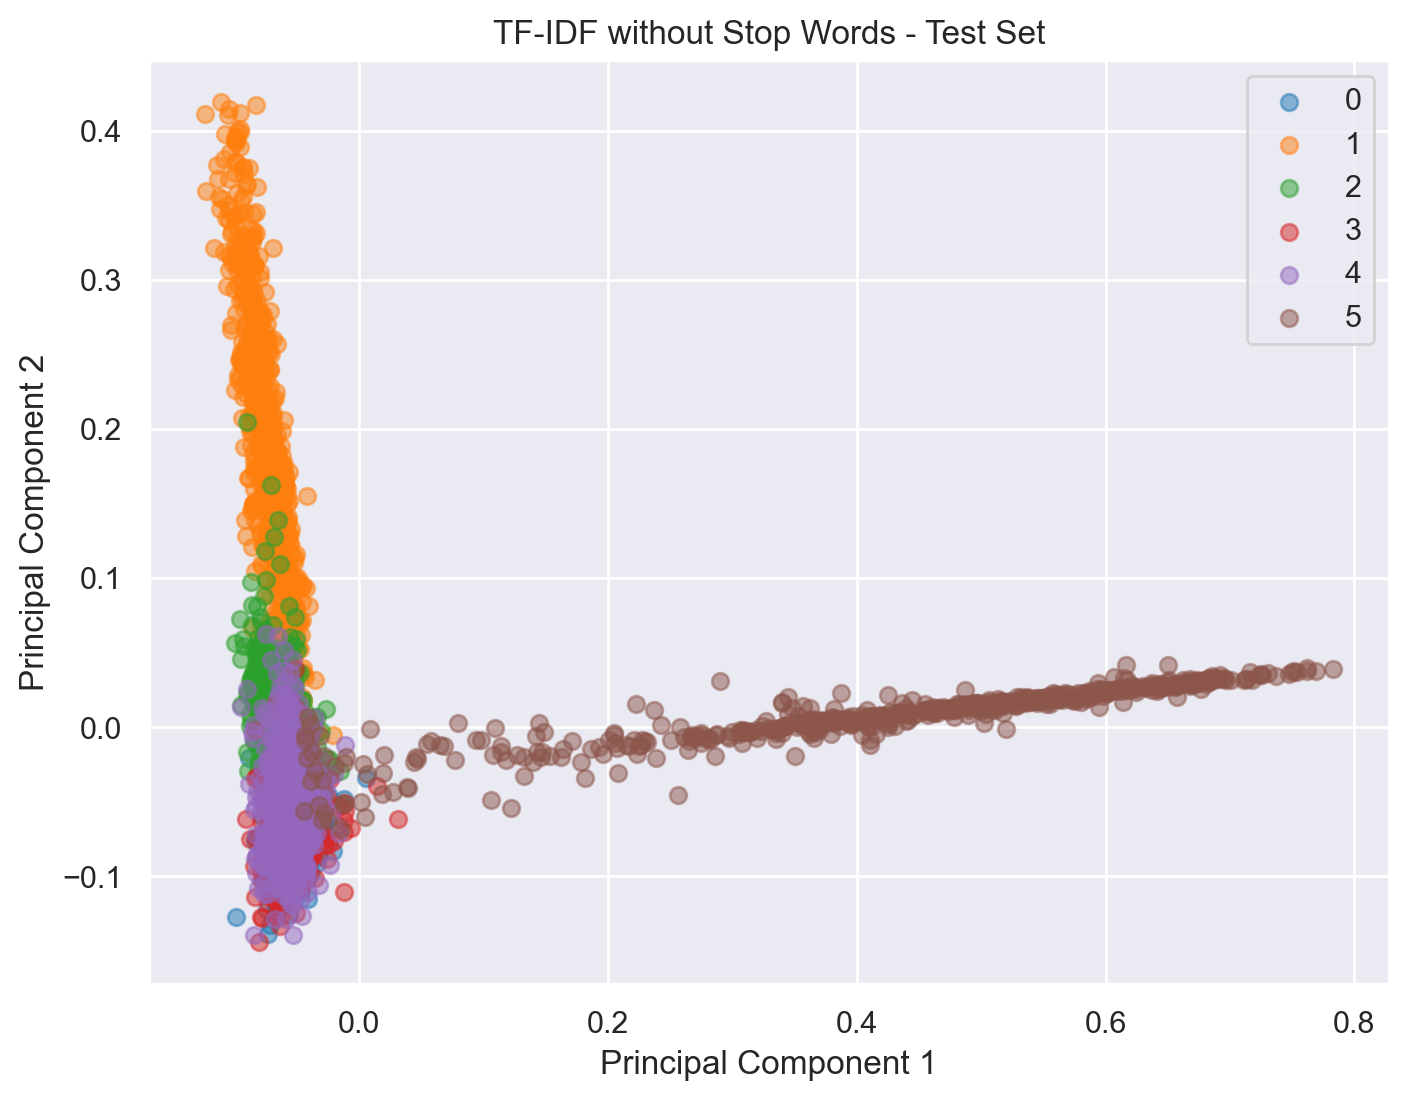

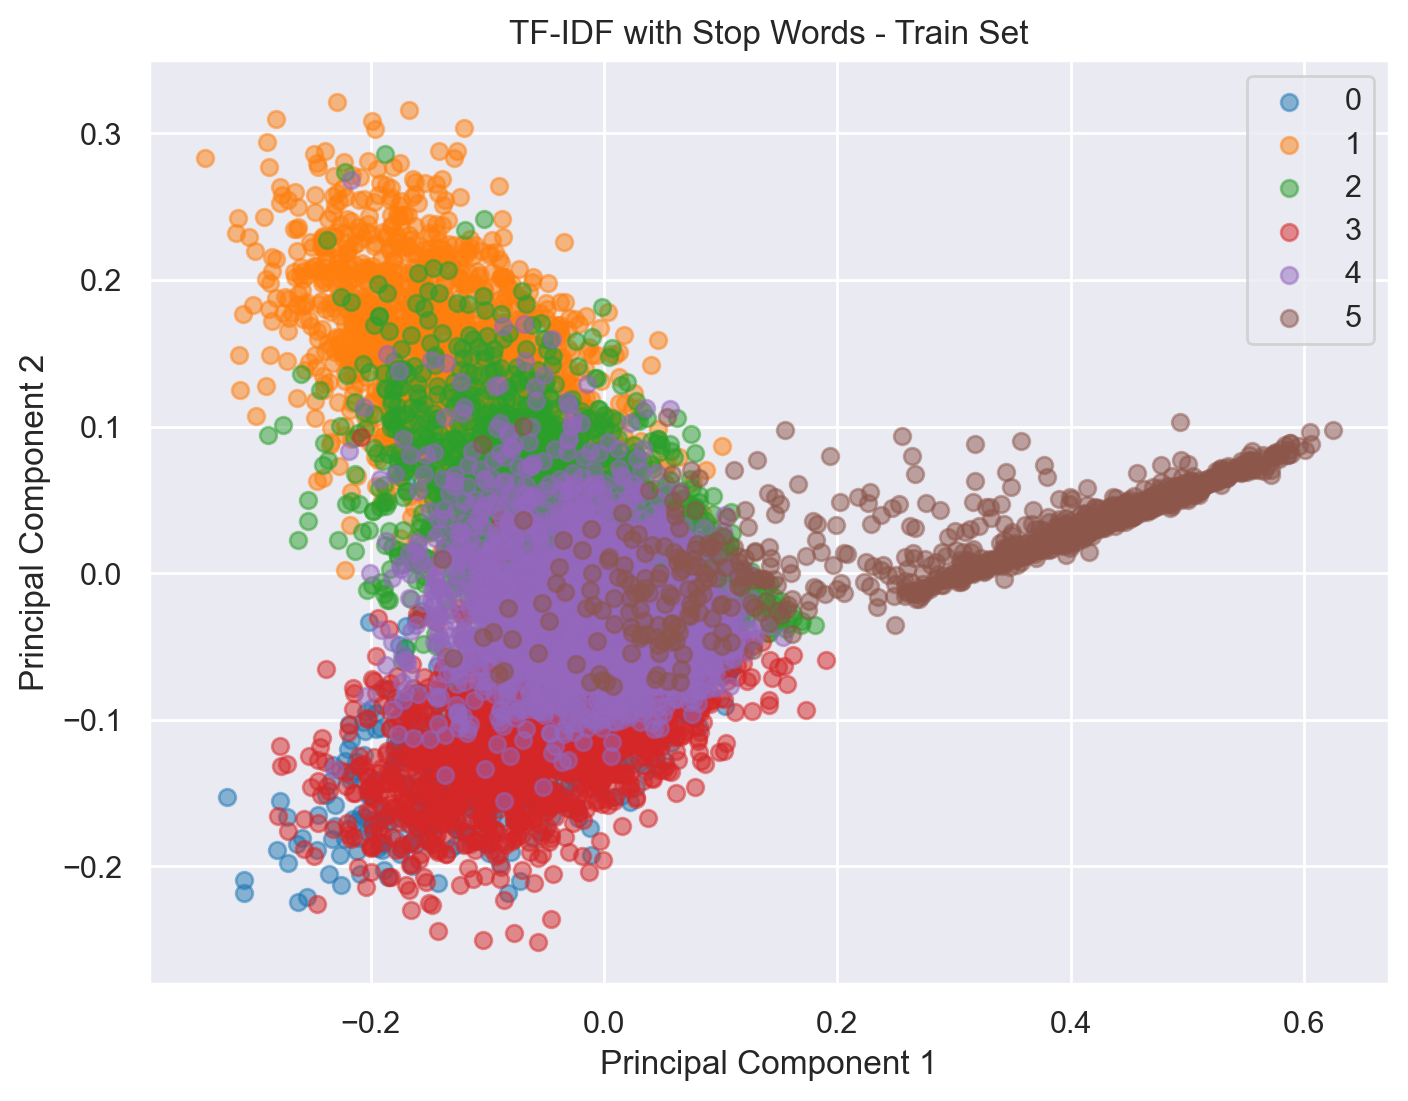

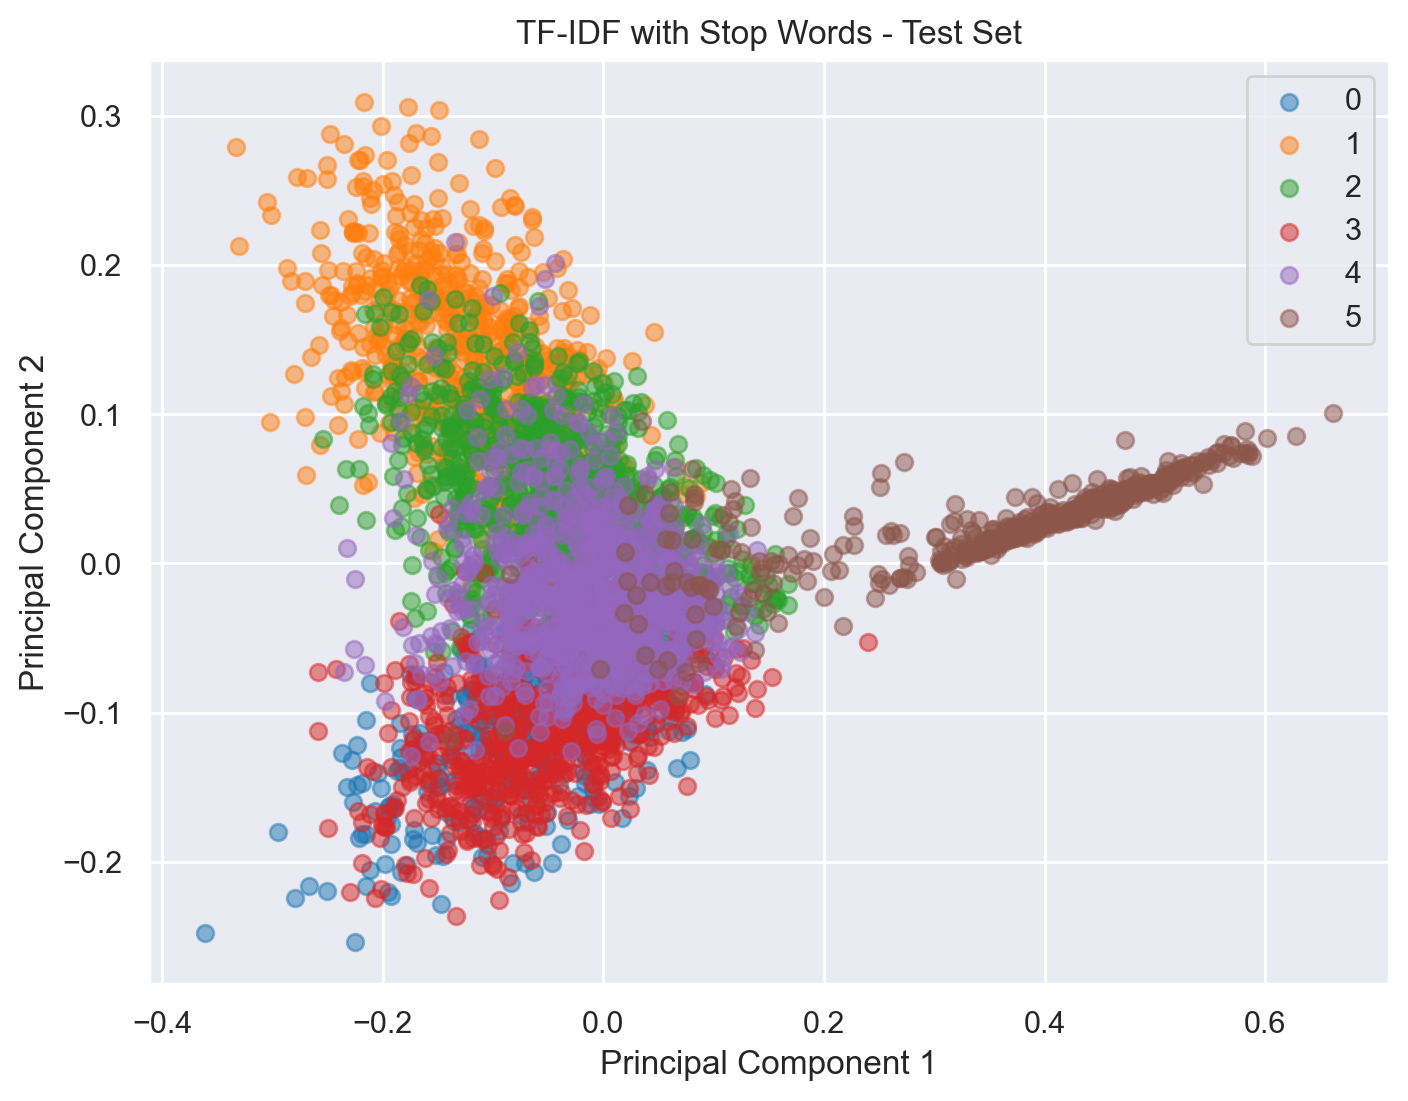

In [21]:
# Initialize classifiers
def apply_pca_and_plot_with_labels(data, labels, title):
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)

    unique_labels = np.unique(labels)
    plt.figure(figsize=(8, 6))

    for label in unique_labels:
        indices = labels == label
        plt.scatter(principal_components[indices, 0], principal_components[indices, 1], alpha=0.5, label=label)

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Apply PCA and plot for the train and test sets
apply_pca_and_plot_with_labels(train_x_sw, train_ys_sw, "TF-IDF without Stop Words - Train Set")
apply_pca_and_plot_with_labels(test_x_sw, test_ys_sw, "TF-IDF without Stop Words - Test Set")
apply_pca_and_plot_with_labels(train_x_nosw, train_ys_nosw, "TF-IDF with Stop Words - Train Set")
apply_pca_and_plot_with_labels(test_x_nosw, test_ys_nosw, "TF-IDF with Stop Words - Test Set")

### Explanation : ###
Comparison: With the "stopwords" parameter we are removing certain features from the original dataset (such as "the", "at", "which", "on") and without the parameter the dataset remains the same. 
However, in terms of accuracy score, we obtain better results from removing those features. The hypothesis is that those features do not bring as much information as the rest of the dataset features which leads ultimately to better accuracy score. We can focus on more useful features.

#### 🚧 TODO: PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test) and plot them

*   Compare the plot with the previous vectorizer with, and without the `stop_words="english"` option

*   Explain the difference breafly

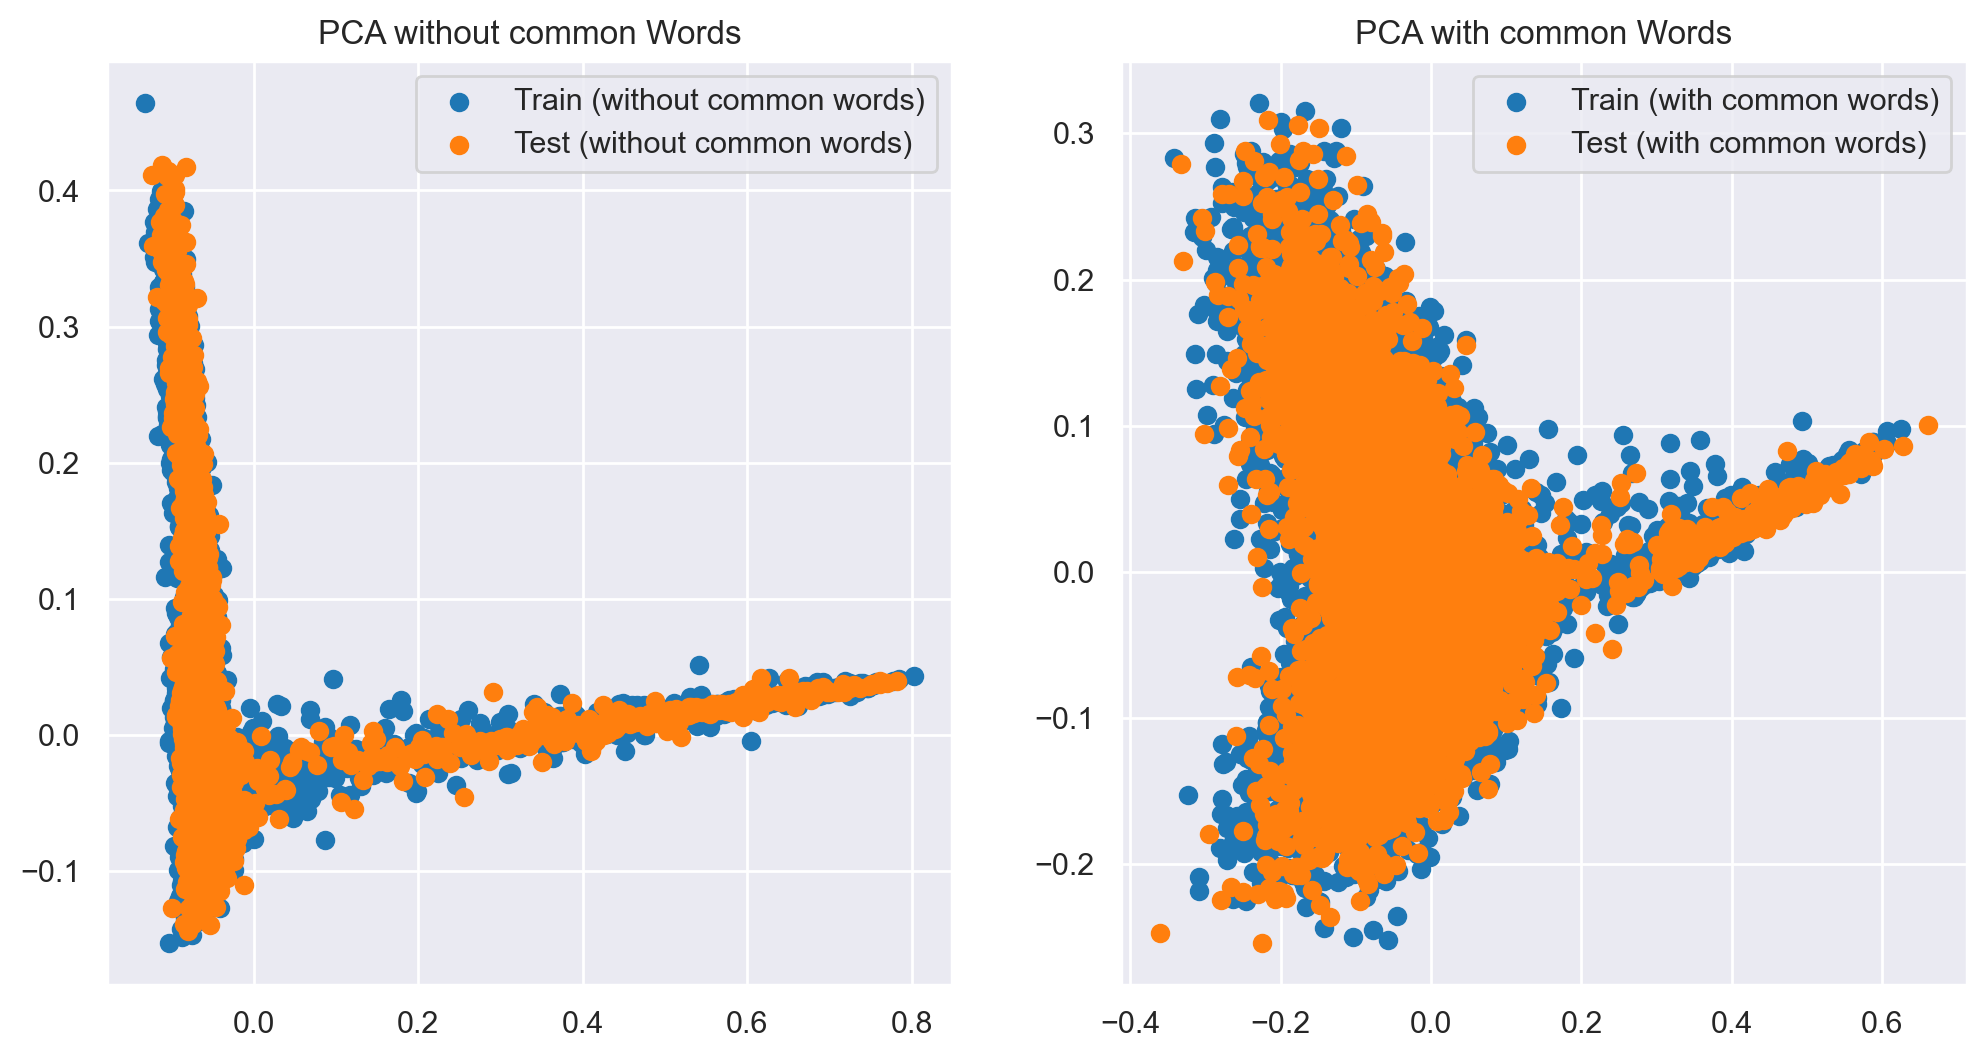

In [22]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(train_x_sw)
# use the PCA model to transform the data
train_x_sw_pca = pca.transform(train_x_sw)
pca.fit(test_x_sw)
test_x_sw_pca = pca.transform(test_x_sw)

pca.fit(train_x_nosw)
train_x_no_sw_pca = pca.transform(train_x_nosw)
pca.fit(test_x_nosw)
test_x_no_sw_pca = pca.transform(test_x_nosw)

# plot the results along with the original data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_x_sw_pca[:, 0], train_x_sw_pca[:, 1], label='Train (without common words)')
plt.scatter(test_x_sw_pca[:, 0], test_x_sw_pca[:, 1], label='Test (without common words)')
plt.title("PCA without common Words")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(train_x_no_sw_pca[:, 0], train_x_no_sw_pca[:, 1], label='Train (with common words)')
plt.scatter(test_x_no_sw_pca[:, 0], test_x_no_sw_pca[:, 1], label='Test (with common words)')
plt.title("PCA with common Words")
plt.legend()

plt.show()

#### 🚧 TODO: Train on PCA

*   Apply PCA to project on 2 dimensions to all vectors (train and test), fitting the PCA only on the training set

*   Train the MultinomialNB and the GaussianNB classifiers on the PCA vectors

    Does it work with both classifiers? Explain breafly.

*   Compare the results with the vectorizer with, and without, the `stop_words="english"` option

*   Analyze the difference breafly

In [ ]:

#TfidfVectorizer
pca = PCA(n_components=2)
pca.fit(train_x_sw)
clf_tfidf_sw = MultinomialNB()
clf_tfidf_nosw = MultinomialNB()
clf_count_gau = GaussianNB()
clf_tfidf_gau = GaussianNB()
# use the PCA model to transform the data
train_x_sw_pca = pca.transform(train_x_sw)
test_x_sw_pca = pca.transform(test_x_sw)
#sw_multinomial = clf_tfidf_sw.fit(train_x_sw_pca, train_ys_sw)
#pred_y_sw_mul = sw_multinomial.predict(test_x_sw)

sw_gaussian = clf_tfidf_gau.fit(train_x_sw_pca, train_ys_sw)
pred_y_sw_gau = sw_gaussian.predict(test_x_sw_pca)

pca.fit(train_x_nosw)
train_x_no_sw_pca = pca.transform(train_x_nosw)
text_x_no_sw_pca = pca.transform(test_x_nosw)
#no_sw_multinomial = clf_tfidf_nosw.fit(train_x_no_sw_pca, train_ys_nosw)
#pred_y_no_sw_mul = no_sw_multinomial.predict(test_x_nosw)
no_sw_gaussian = clf_tfidf_gau.fit(train_x_no_sw_pca, train_ys_nosw)
pred_y_no_sw_gau = no_sw_gaussian.predict(test_x_no_sw_pca)


#print("TfidfVectorizer Accuracy_sw_ without english common words with multionamialnb:", accuracy_score(test_ys_sw, y_pred_sw))
#print(classification_report(test_ys_sw, pred_y_sw_mul))
#print("TfidfVectorizer Accuracy_nosw with english common words with multionamialnb:", accuracy_score(test_ys_nosw, y_pred_nosw))
#print(classification_report(test_ys_nosw, pred_y_no_sw_mul))

print("TfidfVectorizer Accuracy_sw_ without english common words with GaussianNB:", accuracy_score(test_ys_sw, pred_y_sw_gau))
print(classification_report(test_ys_sw, pred_y_sw_gau))
print("TfidfVectorizer Accuracy_nosw with english common words with GaussianNB:", accuracy_score(test_ys_nosw, pred_y_no_sw_gau))
print(classification_report(test_ys_nosw, pred_y_no_sw_gau))

TfidfVectorizer Accuracy_sw_ without english common words with GaussianNB: 0.6050749711649366
              precision    recall  f1-score   support

         0.0       0.33      0.39      0.36       420
         1.0       0.96      0.93      0.94       692
         2.0       0.67      0.57      0.62       935
         3.0       0.46      0.37      0.41       709
         4.0       0.40      0.50      0.45      1054
         5.0       1.00      0.94      0.97       525

    accuracy                           0.61      4335
   macro avg       0.64      0.62      0.62      4335
weighted avg       0.62      0.61      0.61      4335

TfidfVectorizer Accuracy_nosw with english common words with GaussianNB: 0.6509803921568628
              precision    recall  f1-score   support

         0.0       0.25      0.00      0.01       420
         1.0       0.74      0.75      0.75       692
         2.0       0.59      0.51      0.55       935
         3.0       0.60      0.78      0.68       709


Explanation : The MultinomialNB classifier does not support negative inputs, while the PCA transformation may produce negative numbers. MultinomialNB is often used to process count data, such as word frequencies for text data, which are naturally non-negative. When we tried to use MultinomialNB after applying PCA,  we encountered an error, since the result of the PCA transformation contains negative numbers.

#### 🚧 TODO: PCA with more dimensions

*   Try to find the best number of dimensions for the PCA with [`GridSearchCV`](sklearn.model_selection.GridSearchCV)

*   Use pipeline to combine the PCA and the classifier and other potential preprocessing steps

*   Boxplot accuracyies for different PCA dimension values using 

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [30]:
# Define a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('svd', TruncatedSVD()),  # Using TruncatedSVD instead of PCA
    ('clf', GaussianNB())
])

# Define a parameter grid to search for the best number of SVD dimensions
param_grid = {
    'svd__n_components': [10, 50, 100, 200, 300, 500]
}

<Figure size 1000x600 with 0 Axes>

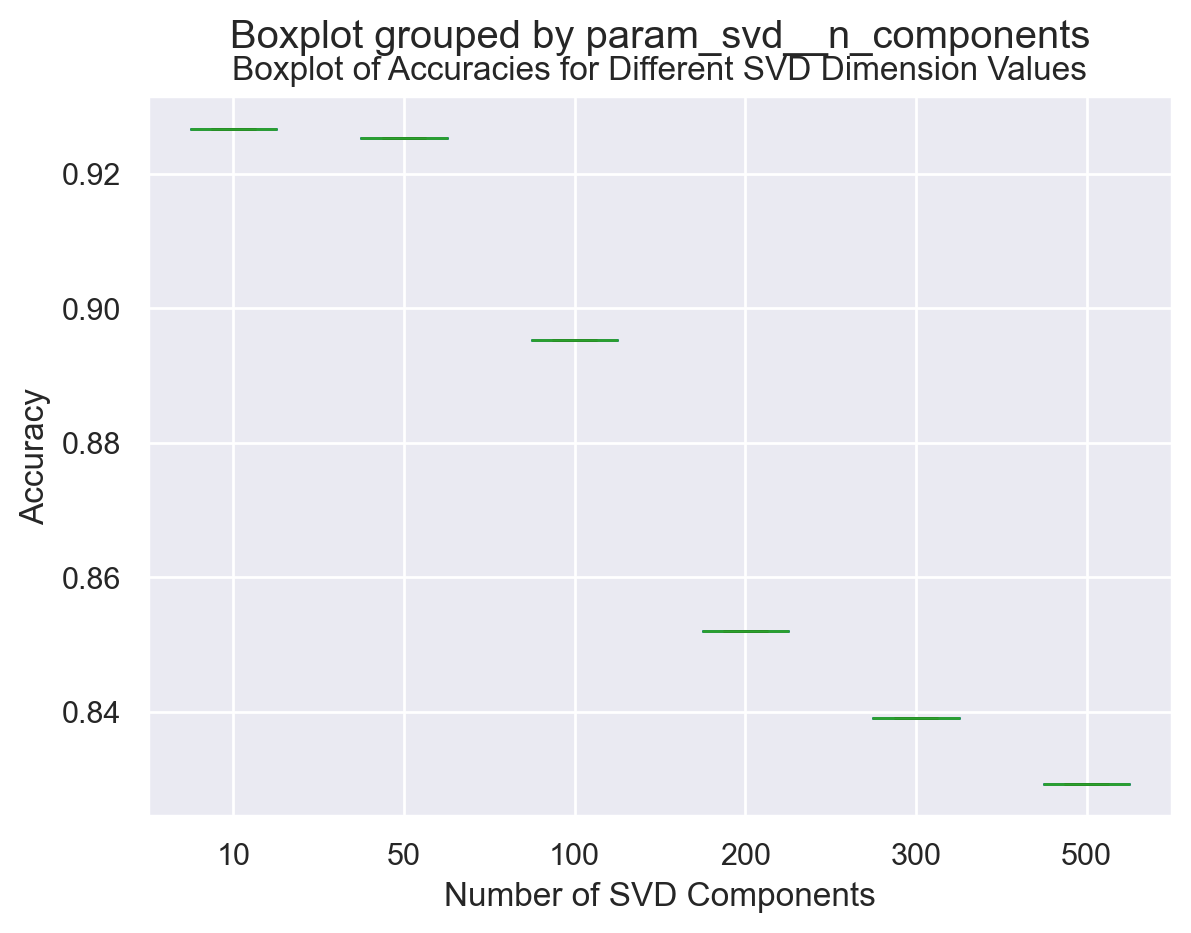

In [31]:
# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(all_df.text, ys)

# Results
results = pd.DataFrame(grid_search.cv_results_)

# Plot the accuracies for different numbers of SVD dimensions
plt.figure(figsize=(10, 6))
results.boxplot(column='mean_test_score', by='param_svd__n_components')
plt.xlabel('Number of SVD Components')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracies for Different SVD Dimension Values')
plt.show()

## N-grams features for text classification

*   We will use bigram in this section

In [32]:
vectorizer_2g = CountVectorizer(
    analyzer="word", ngram_range=(2, 2), max_features=5000,
)
x2gs = vectorizer_2g.fit_transform(all_df.text).toarray()


In [33]:
x2gs.shape

(14450, 5000)

In [34]:
pd.DataFrame(vectorizer_2g.get_feature_names_out(), columns=["bigrams"])

,bigrams
0,17th century
1,18th century
2,19th century
3,20th century
4,24 hours
...,...
4995,your question
4996,your robot
4997,your system
4998,youtube com


In [35]:
train_xs_b, test_xs_b, train_ys_b, test_ys_b = train_test_split(
    x2gs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4335, 5000)


#### 🚧 TODO: Train classification models on n-grams

*   Train on the `CountVectorizer` with ngrams using the `MultinomialNB` classifier

*   Compare the results with the previous "raw" `CountVectorizer`

In [36]:
mNB_bigram = naive_bayes.MultinomialNB()
mNB_bigram.fit(train_xs_b, train_ys_b)
y_pred_bigram = mNB_bigram.predict(test_xs_b)

accuracy = accuracy_score(test_ys_b, y_pred_bigram)
report = classification_report(test_ys_b, y_pred_bigram)

In [37]:
print("Accuracy with Term Frequency: ", accuracy)
print("Classification Report with Term Frequency:\n", report)

Accuracy with Term Frequency:  0.9370242214532872
Classification Report with Term Frequency:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       420
           1       0.91      0.98      0.94       692
           2       0.96      0.92      0.94       935
           3       0.92      0.93      0.93       709
           4       0.94      0.94      0.94      1054
           5       1.00      0.92      0.96       525

    accuracy                           0.94      4335
   macro avg       0.94      0.94      0.94      4335
weighted avg       0.94      0.94      0.94      4335



Explanation : <br>
The metrics are quite similar for both CountVectorizers, which suggests that for our categories, the addition of bigrams does not significantly alter the classifier's ability to correctly label the data. This could be due to several reasons:

1) The classes are distinct enough that single words provide sufficient information for classification.
2) The dataset may not have many distinguishing bigrams that add value over single words.

In practice, bigrams can be more informative for certain kinds of classification tasks, especially those where the sequence of words can change the meaning and thus influence the classification.

For instance, in a class like "robotics", certain bigrams could be particularly telling (e.g., "autonomous vehicle"), whereas in "mythology", names of gods or creatures often appear in pairs and are distinctive (e.g., "Zeus thunderbolt"). However, in this case, the performance metrics suggest that the additional context provided by bigrams doesn't have a significant impact on the overall accuracy of the classification for these categories.

---
## Building an n-gram generator
___

### Let's build character trigrams first

In [38]:
LINE = "This is cool!"
N = 3
[LINE[i : i + N] for i in range(len(LINE) - N + 1)]

['Thi', 'his', 'is ', 's i', ' is', 'is ', 's c', ' co', 'coo', 'ool', 'ol!']

In [39]:
[tuple(LINE[i : i + N]) for i in range(len(LINE) - N + 1)]

[('T', 'h', 'i'),
 ('h', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'i'),
 (' ', 'i', 's'),
 ('i', 's', ' '),
 ('s', ' ', 'c'),
 (' ', 'c', 'o'),
 ('c', 'o', 'o'),
 ('o', 'o', 'l'),
 ('o', 'l', '!')]

In [40]:
LINES = """This is cool!
This is amazing!
But why is this his fish?"""

re.split("\n+", LINES.lower())

['this is cool!', 'this is amazing!', 'but why is this his fish?']

In [41]:
ngrams = collections.Counter()

for line in re.split("\n+", LINES.lower()):
    ngrams.update([line[i : i + N] for i in range(len(line) - N + 1)])

nc_df = pd.DataFrame.from_dict(
    ngrams, orient="index", columns=["freq"]
).sort_values("freq", ascending=False)

nc_df

,freq
is,7
his,4
thi,3
is,3
s i,2
th,1
wh,1
why,1
hy,1
y i,1


### Back to our corpora

#### 🚧 TODO: Build an ngram generator for the `"woodworking"` corpus

*   Tokenize the corpus first with `nltk.word_tokenize`

*   Normalize the tokens by simply simply lowercasing them

*   Give the tokens frequency to the ngram generator

In [42]:
wood_df = all_df[all_df.category == "woodworking"]
wood_df.head()

,text,category,cat_id
id,,,
woodworking.stackexchange_0000009855,Q:\n\nGlue-up for butcher block-style countert...,woodworking,1
woodworking.stackexchange_0000009869,Q:\n\nPlunge router base plate has a bit stick...,woodworking,1
woodworking.stackexchange_0000004395,Q:\n\nWhat is the proper way to sharpen a roun...,woodworking,1
woodworking.stackexchange_0000002928,Q:\n\nWhat woods take stain well?\n\nI'm just ...,woodworking,1
woodworking.stackexchange_0000005921,Q:\n\nHarden soft pine\n\nI made a dutch tool ...,woodworking,1


In [43]:
# intialize n-gram counter
ngrams_counter = collections.Counter()
def filter_tokens(tokens):
    filtered_tokens = []
    for token in tokens:
        token = token.lower()
        if not re.search(r"[0-9/=+()?!`-]", token):
            filtered_tokens.append(token)
    return filtered_tokens

# iterate over all texts
def ngrams(text, N):
    # tokenize
    tokens = word_tokenize(text)
    # nomalize tokens by lowercasing
    normalized_tokens = filter_tokens(tokens)
    # generate n-grams and update counter
    ngrams = [tuple(normalized_tokens[i:i+N]) for i in range(len(normalized_tokens)-N+1)]
    ngrams_counter.update(ngrams)
    
for text in wood_df.text:
    ngrams(text, 3)

#print(ngrams_counter.most_common(10))
ng_df = pd.DataFrame.from_dict(
    ngrams_counter, orient="index", columns=["freq"]
).sort_values("freq", ascending=False)
ng_df

,freq
"(., a, :)",1908
"(., if, you)",1223
"(i, do, n't)",857
"(,, but, i)",684
"(., this, is)",608
...,...
"(commercially, this, type)",1
"(type, of, deep)",1
"(of, deep, profile)",1
"(deep, profile, will)",1


In [44]:
wood_txt = wood_df.iloc[0].text
print(wood_txt[:333])

Q:

Glue-up for butcher block-style countertop

Background
I am working on a butcher block style countertop / tabletop, and am wondering how best to glue the wood together.  The countertop is unfinished maple hardwood floor, with the tongue / groove cut off, flipped on its side.  So, the final result will be about 1 3/4" thick, mos


#### 🚧 TODO: Text generation with ngrams

*   Generate a text of words until a stop word is generated (`.`)

*   Assign a probability to each ngrams based on their frequency

*   Sample from the ngrams based on their probability

*   Try different starting words (use bigrams)

 *Note:* [`default_rng`](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng) is the recommended constructor for random number generation in NumPy.

In [45]:
from numpy.random import default_rng
ngrams_counter = collections.Counter()
N=2

In [46]:
for text in wood_df.text:
    ngrams(text, N)
    
total_count = sum(ngrams_counter.values())
bigram_probabilities = {bigram: count / total_count for bigram, count in ngrams_counter.items()}
bg_df = pd.DataFrame.from_dict(bigram_probabilities, orient="index", columns=["prob"]).sort_values("prob", ascending=False)
bg_df.head(10)

,prob
"(of, the)",0.0057
"(., i)",0.0042
"(,, and)",0.0032
"(,, but)",0.0031
"(in, the)",0.0028
"(., the)",0.0028
"(a, :)",0.0027
"(on, the)",0.0025
"(to, the)",0.0024
"(if, you)",0.0024


In [47]:
import random

In [48]:
# generate text
def generate_text(start_word, bigram_probabilities, stop_word='.'):
    current_word = start_word
    text = [current_word]
    while current_word != stop_word:
        # obtain all bigrams starting with current_word
        candidates = {bigram: prob for bigram, prob in bigram_probabilities.items() if bigram[0] == current_word}
        if not candidates:
            break
        # choose next word based on probability
        next_bigram = random.choices(list(candidates.keys()), weights=candidates.values(), k=1)[0]
        next_word = next_bigram[1]
        text.append(next_word)
        current_word = next_word
    return ' '.join(text)
generate_text('on', bigram_probabilities)


'on the reason it possible to begin with the seller to get a solid colours the one end yet another way , so the table saw .'

### TODO : Improve this algorithm

- Try to fix some possible issues, by handeling exceptions

- Improve the output spacing (no space before comma, etc.) and maybe handle the upper case

- Try on a different domain of our corpus

In [49]:
wood_tokens = wood_df.text.progress_map(word_tokenize)
print(wood_tokens)


  0%|          | 0/2461 [00:00<?, ?it/s]

id
woodworking.stackexchange_0000009855    [Q, :, Glue-up, for, butcher, block-style, cou...
woodworking.stackexchange_0000009869    [Q, :, Plunge, router, base, plate, has, a, bi...
woodworking.stackexchange_0000004395    [Q, :, What, is, the, proper, way, to, sharpen...
woodworking.stackexchange_0000002928    [Q, :, What, woods, take, stain, well, ?, I, '...
woodworking.stackexchange_0000005921    [Q, :, Harden, soft, pine, I, made, a, dutch, ...
                                                              ...                        
woodworking.stackexchange_0000013196    [Q, :, How, To, fasten, rubberwood, desktop, t...
woodworking.stackexchange_0000003385    [Q, :, A, good, way, to, store, wood, ``, outs...
woodworking.stackexchange_0000007861    [Q, :, Are, mortises, with, angled, walls, cut...
woodworking.stackexchange_0000002919    [Q, :, What, is, the, best, drill, bit, for, M...
woodworking.stackexchange_0000005910    [Q, :, Using, 1x4, instead, of, 2x4, for, lami...
Name: t

In [50]:
wood_df.loc[:, "tokens"] = wood_tokens.apply(filter_tokens)
wood_df

/var/folders/tt/pf5xh4vs14v9h68lqh4py2s00000gn/T/ipykernel_65044/3430294922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wood_df.loc[:, "tokens"] = wood_tokens.apply(filter_tokens)


,text,category,cat_id,tokens
id,,,,
woodworking.stackexchange_0000009855,Q:\n\nGlue-up for butcher block-style countert...,woodworking,1,"[q, :, for, butcher, countertop, background, i..."
woodworking.stackexchange_0000009869,Q:\n\nPlunge router base plate has a bit stick...,woodworking,1,"[q, :, plunge, router, base, plate, has, a, bi..."
woodworking.stackexchange_0000004395,Q:\n\nWhat is the proper way to sharpen a roun...,woodworking,1,"[q, :, what, is, the, proper, way, to, sharpen..."
woodworking.stackexchange_0000002928,Q:\n\nWhat woods take stain well?\n\nI'm just ...,woodworking,1,"[q, :, what, woods, take, stain, well, i, 'm, ..."
woodworking.stackexchange_0000005921,Q:\n\nHarden soft pine\n\nI made a dutch tool ...,woodworking,1,"[q, :, harden, soft, pine, i, made, a, dutch, ..."
...,...,...,...,...
woodworking.stackexchange_0000013196,Q:\n\nHow To fasten rubberwood desktop to elec...,woodworking,1,"[q, :, how, to, fasten, rubberwood, desktop, t..."
woodworking.stackexchange_0000003385,"Q:\n\nA good way to store wood ""outside""?\n\nI...",woodworking,1,"[q, :, a, good, way, to, store, wood, outside,..."
woodworking.stackexchange_0000007861,Q:\n\nAre mortises with angled walls cut the s...,woodworking,1,"[q, :, are, mortises, with, angled, walls, cut..."


In [51]:
#Formats the text to be more readable it the end
def format_text(words):
    sentence = ' '.join(words)
    sentence = sentence.\
                replace(" '", "'").\
                replace("''", "").\
                replace(" :", ":").\
                replace("-", " - ").\
                replace(" n't", "n't").\
                replace(' ,', ',').\
                replace(' .', '.')
    return sentence

In [52]:
#Calculates the frequency of n-grams in a corpus of text.
def freq_calculator(tokens, N=2):
    ngrams = collections.Counter()
    for token in tokens:
        ngrams.update([tuple(token[i: i + N]) for i in range(len(token) - N + 1)])
    ngrams_df = pd.DataFrame.from_dict(ngrams, orient="index", columns=["freq"])
    ngrams_df = ngrams_df.sort_values("freq", ascending=False)
    return ngrams_df
wood_ng_df = freq_calculator(wood_df.tokens)
wood_ng_df

,freq
"(of, the)",7541
"(., i)",5526
"(,, and)",4214
"(,, but)",4063
"(in, the)",3773
...,...
"(entirely, upon)",1
"(upon, this)",1
"(this, molding)",1
"(would, face)",1


In [54]:
# Text generator function
def text_generator(cat_tokens, phrase):
    # Checks if the phrase is in the vocabulary
    if not any(phrase in ' '.join(tokens) for tokens in cat_tokens):
        raise ValueError(f'"{phrase}" is not in the vocabulary.')

    current_word = phrase.split()
    stop_word = current_word[-1]

    # Handles unigram or bigram as the start word
    if len(current_word) == 1:
        freq_df = freq_calculator(cat_tokens)
        check_word = (current_word[0],)
    elif len(current_word) == 2:
        freq_df = freq_calculator(cat_tokens, N=3)
        check_word = tuple(current_word)
    else:
        raise ValueError('The start word must be a unigram or bigram.')

    generated_text = list(current_word)
    rng = np.random.default_rng()  # Random number generator for word selection

    # Generates text until a full stop is reached
    while stop_word != '.':
        # Identifies potential next words and their frequencies
        next_words = [(pair[-1], freq_df.at[pair, 'freq']) for pair in freq_df.index if pair[:-1] == check_word]
        
        # Breaks if no next words are found or if all frequencies are zero
        if not next_words or all(freq == 0 for _, freq in next_words):
            break

        # Calculates the total frequency and probabilities
        total_freq = sum(freq for _, freq in next_words)
        probabilities = [freq / total_freq for _, freq in next_words]

        # Randomly selects the next word based on the probabilities
        next_word = rng.choice([word for word, _ in next_words], p=probabilities)

        generated_text.append(next_word)
        stop_word = next_word

        # Updates the check word for the next iteration
        if len(check_word) == 1:
            check_word = (next_word,)
        else:
            check_word = (check_word[-1], next_word)
    # Returns formatted text
    return format_text(generated_text)

In [58]:
print(text_generator(wood_df.tokens, 'of this'))

of this in future obviously the container should be done to break i've done this all with turbulent flow not like the kataba in your own, see previous question, i.


### Application of the text generator in the "Mythology" corpus

In [56]:
mythology_df = all_df[all_df.category == "mythology"]
mythology_tokens = mythology_df.text.progress_map(word_tokenize)
mythology_df.loc[:, "tokens"] = mythology_tokens.apply(filter_tokens)

  0%|          | 0/1428 [00:00<?, ?it/s]

/var/folders/tt/pf5xh4vs14v9h68lqh4py2s00000gn/T/ipykernel_65044/3275411260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mythology_df.loc[:, "tokens"] = mythology_tokens.apply(filter_tokens)


In [61]:
print(text_generator(mythology_df.tokens, 'say why'))

say why hope stayed into the corner, the great lid of the characters used in the west, dragons, she who is the transfer of the haihayas, he is the name, starting with creation of further children together at all and go with ultimate power and strength of their legends are rooted in their confrontations with opponents.


---